In [4]:
# Importing the necessary modules
import findspark
findspark.init()

# Initialize a SparkSession
from pyspark.sql import SparkSession

# Creating SparkSession
spark = SparkSession.builder.appName('TP').getOrCreate()

# Calling the session variable object
spark

Loading data sets

In [5]:
netflix_url = "https://raw.githubusercontent.com/AmandaClinnie/DS625-TeamProject/main/netflix_titles.csv"
disney_url = "https://raw.githubusercontent.com/AmandaClinnie/DS625-TeamProject/main/disney_plus_titles.csv"

from pyspark import SparkFiles
spark.sparkContext.addFile(netflix_url)
spark.sparkContext.addFile(disney_url)

netflix_df = spark.read.csv("file:///"+SparkFiles.get("netflix_titles.csv"), header=True, inferSchema= True)
disney_df = spark.read.csv("file:///"+SparkFiles.get("disney_plus_titles.csv"), header=True, inferSchema= True)

In [6]:
netflix_df.printSchema()
disney_df.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



In [7]:
netflix_df.show(3)
disney_df.show(3)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                null|United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|           null|Ama Qamata, Khosi...| South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...|         null|Septem

In [8]:
netflix_df.createOrReplaceTempView("Netflix")
disney_df.createOrReplaceTempView("Disney")

# Data Cleaning

In [9]:
# remove (do not select) show_id and date_added columns
# convert columns with multiple values to arrays
netflix_clean = spark.sql("SELECT type, \
                  title, \
                  SPLIT(director, ',') AS director, \
                  SPLIT(cast, ',') AS cast, \
                  SPLIT(country, ',') AS country, \
                  release_year, \
                  rating, \
                  duration, \
                  SPLIT(listed_in, ',') AS listed_in, \
                  description \
                  FROM Netflix")
netflix_clean.createOrReplaceTempView("Netflix1")

disney_clean = spark.sql("SELECT type, \
                  title, \
                  SPLIT(director, ',') AS director, \
                  SPLIT(cast, ',') AS cast, \
                  SPLIT(country, ',') AS country, \
                  release_year, \
                  rating, \
                  duration, \
                  SPLIT(listed_in, ',') AS listed_in, \
                  description \
                  FROM Disney")
disney_clean.createOrReplaceTempView("Disney1")

In [10]:
# test duration and listed_in columns to see if they vary between platforms
overlap = spark.sql("SELECT Netflix1.title, Netflix1.duration, Disney1.duration,\
                     Netflix1.listed_in, Disney1.listed_in FROM Netflix1 \
                     INNER JOIN Disney1 ON Netflix1.title = Disney1.title")
overlap.show(5, truncate=False)
# there is variation - worth keeping each dataset separate

+----------------+---------+---------+--------------------------------------------------------+-----------------------------------------------------+
|title           |duration |duration |listed_in                                               |listed_in                                            |
+----------------+---------+---------+--------------------------------------------------------+-----------------------------------------------------+
|PJ Masks        |3 Seasons|5 Seasons|[Kids' TV]                                              |[Action-Adventure,  Animation,  Kids]                |
|Once Upon a Time|1 Season |7 Seasons|[International TV Shows,  Romantic TV Shows,  TV Dramas]|[Action-Adventure,  Fantasy,  Soap Opera / Melodrama]|
|Gigantosaurus   |1 Season |2 Seasons|[Kids' TV]                                              |[Action-Adventure,  Animation,  Kids]                |
|Becoming        |89 min   |1 Season |[Documentaries]                                         |[Anth

In [11]:
netflix_nulls = spark.sql("SELECT COUNT (*) AS type_nulls FROM Netflix1 WHERE type IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS title_nulls FROM Netflix1 WHERE title IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS director_nulls FROM Netflix1 WHERE director IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS cast_nulls FROM Netflix1 WHERE cast IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS country_nulls FROM Netflix1 WHERE country IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS release_year_nulls FROM Netflix1 WHERE release_year IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS rating_nulls FROM Netflix1 WHERE rating IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS duration_nulls FROM Netflix1 WHERE duration IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS listed_in_nulls FROM Netflix1 WHERE listed_in IS NULL")
netflix_nulls.show()

netflix_nulls = spark.sql("SELECT COUNT (*) AS desctiption_nulls FROM Netflix1 WHERE description IS NULL")
netflix_nulls.show()

+----------+
|type_nulls|
+----------+
|         1|
+----------+

+-----------+
|title_nulls|
+-----------+
|          2|
+-----------+

+--------------+
|director_nulls|
+--------------+
|          2636|
+--------------+

+----------+
|cast_nulls|
+----------+
|       826|
+----------+

+-------------+
|country_nulls|
+-------------+
|          832|
+-------------+

+------------------+
|release_year_nulls|
+------------------+
|                 2|
+------------------+

+------------+
|rating_nulls|
+------------+
|           6|
+------------+

+--------------+
|duration_nulls|
+--------------+
|             5|
+--------------+

+---------------+
|listed_in_nulls|
+---------------+
|              3|
+---------------+

+-----------------+
|desctiption_nulls|
+-----------------+
|                3|
+-----------------+



In [12]:
# remove rows for columns having <10 null values
# director, cast & country columns not as important to be NOT NULL/
#  can be dealt with later
netflix_clean_nulls = spark.sql("SELECT type, \
                  title, \
                  director, \
                  cast, \
                  country, \
                  release_year, \
                  rating, \
                  duration, \
                  listed_in, \
                  description \
                  FROM Netflix1 \
                  WHERE type IS NOT NULL AND \
                  title IS NOT NULL AND \
                  release_year IS NOT NULL AND \
                  rating IS NOT NULL AND \
                  duration IS NOT NULL AND \
                  listed_in IS NOT NULL AND \
                  description IS NOT NULL")
netflix_clean_nulls.createOrReplaceTempView("Netflix2")

In [13]:
disney_nulls = spark.sql("SELECT COUNT (*) AS type_nulls FROM Disney1 WHERE type IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS title_nulls FROM Disney1 WHERE title IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS director_nulls FROM Disney1 WHERE director IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS cast_nulls FROM Disney1 WHERE cast IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS country_nulls FROM Disney1 WHERE country IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS release_year_nulls FROM Disney1 WHERE release_year IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS rating_nulls FROM Disney1 WHERE rating IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS duration_nulls FROM Disney1 WHERE duration IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS listed_in_nulls FROM Disney1 WHERE listed_in IS NULL")
disney_nulls.show()

disney_nulls = spark.sql("SELECT COUNT (*) AS desctiption_nulls FROM Disney1 WHERE description IS NULL")
disney_nulls.show()

+----------+
|type_nulls|
+----------+
|         0|
+----------+

+-----------+
|title_nulls|
+-----------+
|          0|
+-----------+

+--------------+
|director_nulls|
+--------------+
|           473|
+--------------+

+----------+
|cast_nulls|
+----------+
|       190|
+----------+

+-------------+
|country_nulls|
+-------------+
|          218|
+-------------+

+------------------+
|release_year_nulls|
+------------------+
|                 0|
+------------------+

+------------+
|rating_nulls|
+------------+
|           3|
+------------+

+--------------+
|duration_nulls|
+--------------+
|             0|
+--------------+

+---------------+
|listed_in_nulls|
+---------------+
|              1|
+---------------+

+-----------------+
|desctiption_nulls|
+-----------------+
|                0|
+-----------------+



In [14]:
# remove rows for columns having <10 null values
# director, cast & country columns not as important to be NOT NULL/
#  can be dealt with later
disney_clean_nulls = spark.sql("SELECT type, \
                  title, \
                  director, \
                  cast, \
                  country, \
                  release_year, \
                  rating, \
                  duration, \
                  listed_in, \
                  description \
                  FROM Disney1 \
                  WHERE rating IS NOT NULL AND \
                  listed_in IS NOT NULL")
disney_clean_nulls.createOrReplaceTempView("Disney2")

NETFLIX table: Netflix2

DISNEY table: Disney2

In [15]:
# table counts
spark.sql("SELECT COUNT (*) FROM Netflix2").show()
spark.sql("SELECT COUNT (*) FROM Disney2").show()

+--------+
|count(1)|
+--------+
|    8799|
+--------+

+--------+
|count(1)|
+--------+
|    1446|
+--------+



# Data Exploration and Analysis

In [16]:
spark.sql("SELECT * FROM Disney2").show()

+-------+--------------------+--------------------+--------------------+--------------------+------------+------+----------+--------------------+--------------------+
|   type|               title|            director|                cast|             country|release_year|rating|  duration|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+--------------------+------------+------+----------+--------------------+--------------------+
|  Movie|Duck the Halls: A...|[Alonso Ramirez R...|[Chris Diamantopo...|                null|        2016|  TV-G|    23 min|[Animation,  Family]|Join Mickey and t...|
|  Movie|Ernest Saves Chri...|       [John Cherry]|[Jim Varney,  Noe...|                null|        1988|    PG|    91 min|            [Comedy]|Santa Claus passe...|
|  Movie|Ice Age: A Mammot...|      [Karen Disher]|[Raymond Albert R...|     [United States]|        2011|  TV-G|    23 min|[Animation,  Come...|Sid the Sloth is ...

In [136]:
spark.sql("SELECT * FROM Netflix2").show()

+-------+--------------------+--------------------+--------------------+--------------------+------------+------+---------+--------------------+--------------------+
|   type|               title|            director|                cast|             country|release_year|rating| duration|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+--------------------+------------+------+---------+--------------------+--------------------+
|  Movie|Dick Johnson Is Dead|   [Kirsten Johnson]|                null|     [United States]|        2020| PG-13|   90 min|     [Documentaries]|As her father nea...|
|TV Show|       Blood & Water|                null|[Ama Qamata,  Kho...|      [South Africa]|        2021| TV-MA|2 Seasons|[International TV...|After crossing pa...|
|TV Show|           Ganglands|   [Julien Leclercq]|[Sami Bouajila,  ...|                null|        2021| TV-MA| 1 Season|[Crime TV Shows, ...|To protect his fa...|
|TV 

In [17]:
#queries looking for the total number of PG rated movies on each platform in case that is a factor towards which subscription a customer chooses. 
spark.sql("SELECT COUNT (*) AS Number_of_PG_Movies_On_Netflix FROM Netflix2 WHERE rating == 'PG' AND type == 'Movie'").show()
spark.sql("SELECT COUNT (*) AS Number_of_PG_Movies_On_Disney FROM Disney2 WHERE rating == 'PG'AND type == 'Movie'").show()

+------------------------------+
|Number_of_PG_Movies_On_Netflix|
+------------------------------+
|                           286|
+------------------------------+

+-----------------------------+
|Number_of_PG_Movies_On_Disney|
+-----------------------------+
|                          234|
+-----------------------------+



In [18]:
mpaaNetflix = spark.sql("SELECT rating, COUNT (*) AS Number_of_Movies_On_Netflix FROM Netflix2 WHERE type == 'Movie' GROUP BY rating ORDER BY Number_of_Movies_On_Netflix DESC")

mpaaNetflix.show()

+-----------------+---------------------------+
|           rating|Number_of_Movies_On_Netflix|
+-----------------+---------------------------+
|            TV-MA|                       2052|
|            TV-14|                       1426|
|                R|                        794|
|            TV-PG|                        539|
|            PG-13|                        489|
|               PG|                        286|
|            TV-Y7|                        139|
|             TV-Y|                        131|
|             TV-G|                        126|
|               NR|                         75|
|                G|                         41|
|         TV-Y7-FV|                          5|
|               UR|                          3|
|            NC-17|                          3|
|             2021|                          2|
| November 1, 2020|                          1|
| Shavidee Trotter|                          1|
|    Maury Chaykin|                     

In [19]:
Disney_Movies = spark.sql("SELECT title, duration FROM Disney2 WHERE type == 'Movie'")

Disney_Movies.show()

+--------------------+--------+
|               title|duration|
+--------------------+--------+
|Duck the Halls: A...|  23 min|
|Ernest Saves Chri...|  91 min|
|Ice Age: A Mammot...|  23 min|
|The Queen Family ...|  41 min|
|   Becoming Cousteau|  94 min|
|A Muppets Christm...|  45 min|
|Adventure Thru th...|  59 min|
|  Puppy for Hanukkah|   4 min|
|     The Pixar Story|  91 min|
|America the Beaut...|   2 min|
|             Baymax!|   1 min|
|        Ciao Alberto|   8 min|
|           Enchanted| 110 min|
|               Feast|   8 min|
|        Frozen Fever|  11 min|
|        Get a Horse!|   7 min|
|Home Sweet Home A...|  95 min|
|       Jungle Cruise| 129 min|
|Limitless with Ch...|   2 min|
|Marvel Studios’ 2...|  14 min|
+--------------------+--------+
only showing top 20 rows



In [20]:
from pyspark.sql.functions import col, concat_ws

In [21]:
disneyEDA = disney_clean_nulls

In [22]:
disneyEDA = disneyEDA.withColumn("director", concat_ws(",", col("director")))
disneyEDA = disneyEDA.withColumn("cast", concat_ws(",", col("cast")))
disneyEDA = disneyEDA.withColumn("country", concat_ws(",", col("country")))
disneyEDA = disneyEDA.withColumn("listed_in", concat_ws(",", col("listed_in")))
disneyEDA.printSchema()

disneyEDA.createOrReplaceTempView("DisneyEDA")

root
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = false)
 |-- cast: string (nullable = false)
 |-- country: string (nullable = false)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = false)
 |-- description: string (nullable = true)



In [23]:
spark.sql("SELECT * FROM DisneyEDA").show()

+-------+--------------------+--------------------+--------------------+--------------------+------------+------+----------+--------------------+--------------------+
|   type|               title|            director|                cast|             country|release_year|rating|  duration|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+--------------------+------------+------+----------+--------------------+--------------------+
|  Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|                    |        2016|  TV-G|    23 min|   Animation, Family|Join Mickey and t...|
|  Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|                    |        1988|    PG|    91 min|              Comedy|Santa Claus passe...|
|  Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|       United States|        2011|  TV-G|    23 min|Animation, Comedy...|Sid the Sloth is ...

In [24]:
disneyEDA.where(col("director") == "John Cherry").show()

+-----+--------------------+-----------+--------------------+-------+------------+------+--------+---------+--------------------+
| type|               title|   director|                cast|country|release_year|rating|duration|listed_in|         description|
+-----+--------------------+-----------+--------------------+-------+------------+------+--------+---------+--------------------+
|Movie|Ernest Saves Chri...|John Cherry|Jim Varney, Noell...|       |        1988|    PG|  91 min|   Comedy|Santa Claus passe...|
+-----+--------------------+-----------+--------------------+-------+------------+------+--------+---------+--------------------+



In [25]:
mpaaDisney = spark.sql("SELECT rating, COUNT (*) AS Number_of_Movies_On_Disney FROM Disney2 WHERE type == 'Movie' GROUP BY rating ORDER BY Number_of_Movies_On_Disney DESC")

mpaaDisney.show()

+-----------------+--------------------------+
|           rating|Number_of_Movies_On_Disney|
+-----------------+--------------------------+
|                G|                       253|
|               PG|                       234|
|             TV-G|                       233|
|            TV-PG|                       181|
|            PG-13|                        66|
|            TV-14|                        37|
|            TV-Y7|                        36|
|         TV-Y7-FV|                         6|
|             TV-Y|                         3|
|December 25, 2020|                         1|
+-----------------+--------------------------+



In [26]:
disneyEDA.where(col("listed_in") == "Comedy").show()

+-------+--------------------+------------+--------------------+--------------------+------------+------+---------+---------+--------------------+
|   type|               title|    director|                cast|             country|release_year|rating| duration|listed_in|         description|
+-------+--------------------+------------+--------------------+--------------------+------------+------+---------+---------+--------------------+
|  Movie|Ernest Saves Chri...| John Cherry|Jim Varney, Noell...|                    |        1988|    PG|   91 min|   Comedy|Santa Claus passe...|
|  Movie|Just Roll With It...|            |Tobie Windham, Su...|                    |        2019|     G|   52 min|   Comedy|The Bennett-Blatt...|
|  Movie|Far Away From Rav...|            |Raven-Symoné, Iss...|                    |        2021|  TV-G|   11 min|   Comedy|Our gang is off f...|
|TV Show|  Wander Over Yonder|            |Jack McBrayer, Ap...|United States, Ca...|        2013| TV-Y7|2 Seasons|   

In [141]:
#queries showing the count of different mixed category shows and movies
spark.sql("SELECT listed_in, COUNT(array_contains(listed_in, 'Animation')) as CountOnDisney FROM Disney2 WHERE array_contains(listed_in, 'Animation') == True GROUP BY listed_in ORDER BY CountOnDisney DESC").show()

+--------------------+-------------+
|           listed_in|CountOnDisney|
+--------------------+-------------+
|[Animation,  Come...|          123|
|[Animation,  Fami...|           31|
|[Animation,  Family]|           26|
|  [Animation,  Kids]|           17|
|[Animation,  Fami...|           16|
|[Animation,  Come...|            9|
|[Animation,  Fant...|            7|
|[Animation,  Budd...|            6|
|[Animation,  Fami...|            4|
|[Animation,  Comedy]|            4|
|[Animation,  Come...|            4|
|[Animation,  Fami...|            4|
|[Animation,  Kids...|            4|
|[Animation,  Fami...|            4|
|[Animation,  Anth...|            4|
|[Animation,  Anth...|            3|
|[Animation,  Comi...|            3|
|[Animation,  Dram...|            3|
|[Animation,  Comi...|            3|
|[Animation,  Come...|            3|
+--------------------+-------------+
only showing top 20 rows



In [143]:
spark.sql("SELECT listed_in, COUNT(array_contains(listed_in, 'Documentaries')) as CountOnNetflix FROM Netflix2 WHERE array_contains(listed_in, 'Documentaries') == True GROUP BY listed_in ORDER BY CountOnNetflix DESC").show()

+--------------------+--------------+
|           listed_in|CountOnNetflix|
+--------------------+--------------+
|     [Documentaries]|           358|
|[Documentaries,  ...|           186|
|[Documentaries,  ...|            81|
|[Documentaries,  ...|            65|
|[Documentaries,  ...|            44|
|[Documentaries,  ...|            41|
|[Documentaries,  ...|            22|
|[Documentaries,  ...|             8|
|[Documentaries,  ...|             7|
|[Documentaries,  ...|             3|
|[Documentaries,  ...|             2|
|[Documentaries,  ...|             2|
|[Documentaries,  ...|             2|
|[Documentaries,  ...|             2|
|[Documentaries,  ...|             2|
|[Documentaries,  ...|             1|
|[Documentaries,  ...|             1|
+--------------------+--------------+



In [146]:
#queries for the total count of categories in each streaming services. 
from pyspark.sql.functions import array_contains

disneyAnimated = spark.sql("SELECT COUNT(array_contains(listed_in, 'Animation')) AS Disney_Animateds FROM Disney2 WHERE array_contains(listed_in, 'Animation') == true").show()
disneyAction = spark.sql("SELECT COUNT(array_contains(listed_in, 'Action-Adventure')) AS Disney_Action_Adventures FROM Disney2 WHERE array_contains(listed_in, 'Action-Adventure') == true").show()

netflixDocs = spark.sql("SELECT COUNT(array_contains(listed_in, 'Documentaries')) AS Netflix_Documentaries FROM Netflix2 WHERE array_contains(listed_in, 'Documentaries') == true").show()
disneyDocs = spark.sql("SELECT COUNT(array_contains(listed_in, 'Documentary')) AS Disney_Documentaries FROM Disney2 WHERE array_contains(listed_in, 'Documentary') == true").show()

+----------------+
|Disney_Animateds|
+----------------+
|             318|
+----------------+

+------------------------+
|Disney_Action_Adventures|
+------------------------+
|                     451|
+------------------------+

+---------------------+
|Netflix_Documentaries|
+---------------------+
|                  827|
+---------------------+

+--------------------+
|Disney_Documentaries|
+--------------------+
|                  65|
+--------------------+



In [29]:
netflixEDA = netflix_clean_nulls
netflixEDA.printSchema()

root
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cast: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)



In [30]:
# Converting list to Strings
netflixEDA = netflixEDA.withColumn("director", concat_ws(",", col("director")))
netflixEDA = netflixEDA.withColumn("cast", concat_ws(",", col("cast")))
netflixEDA = netflixEDA.withColumn("country", concat_ws(",", col("country")))
netflixEDA = netflixEDA.withColumn("listed_in", concat_ws(",", col("listed_in")))
netflixEDA.printSchema()

root
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = false)
 |-- cast: string (nullable = false)
 |-- country: string (nullable = false)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = false)
 |-- description: string (nullable = true)



# Machine Learning

In [31]:
# Importing necessary modules

from pyspark.ml.feature import (CountVectorizer, RegexTokenizer, StopWordsRemover, IDF, StringIndexer, VectorAssembler)
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# A. Disney Data

In [32]:
# Selecting a subset of the Disney dataset 
DisneyML = disneyEDA.select("type", "title", "director", "cast", "rating", "listed_in", "description")
DisneyML.show()

+-------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|   type|               title|            director|                cast|rating|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|  Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|
|  Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|
|  Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|
|  Movie|The Queen Family ...|     Hamish Hamilton|Darren Criss, Ada...| TV-PG|             Musical|This is real life...|
|  Movie|   Becoming Cousteau|          Liz Garbus|Jacques Yves Cous...| PG-13|Biographical, Doc...|An inside look at...|
|TV Show|             Ha

In [33]:
# Checking distinct elements from the rating feature and potentially use it as the label for NaiveBayes model
DisneyML.select("rating").distinct().show()
DisneyML.select("rating").distinct().count()

+-----------------+
|           rating|
+-----------------+
|             TV-Y|
|December 25, 2020|
|               PG|
|    United States|
|         TV-Y7-FV|
|            TV-PG|
|                G|
|            TV-14|
|             TV-G|
|            TV-Y7|
|            PG-13|
+-----------------+



11

# A.1 Model Building

a. Natural Language Processing

In [34]:
from pyspark.sql.functions import length

# Using title length for transforming features later on
DisneyNLP = DisneyML.withColumn('title_length', length(DisneyML['title']))
DisneyNLP.show(3)

+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+
| type|               title|            director|                cast|rating|           listed_in|         description|title_length|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|          48|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|          22|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|          28|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+
only showing top 3 rows



Model 1: Using title and title word count as features and rating as label

In [35]:
# Tokenize words in title column
tokenizer1 = RegexTokenizer(inputCol= 'title', outputCol='disney_t_words', pattern='\\W')
tokenized1 = tokenizer1.transform(DisneyNLP)
tokenized1.show(5)

# Remove stopwords in tokenized Disney_words column
Disney_remover = StopWordsRemover(inputCol='disney_t_words', outputCol='filtered_title')
removed_Dis = Disney_remover.transform(tokenized1)

# Processing title column
Disney_cv = CountVectorizer(inputCol='filtered_title', outputCol='vec_title')
Disney_idf = IDF(inputCol='vec_title', outputCol='Disney_tfidf')
Disney_numeric = StringIndexer(inputCol='rating', outputCol='label')
Disney_Assembler = VectorAssembler(inputCols=['Disney_tfidf','title_length'], outputCol='features')

+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+
| type|               title|            director|                cast|rating|           listed_in|         description|title_length|      disney_t_words|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|          48|[duck, the, halls...|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|          22|[ernest, saves, c...|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|          28|[ice, age, a, mam...|
|Movie|The Queen Family ...|     Hamish Hamilton|Darren Criss, Ada...| TV-PG

In [36]:
# Creaing data pipeline
Disney_pipeline = Pipeline(stages=[Disney_numeric, tokenizer1, Disney_remover, Disney_cv, Disney_idf, Disney_Assembler])

Disney_fit = Disney_pipeline.fit(DisneyNLP)
Disney_clean = Disney_fit.transform(DisneyNLP)
Disney_cleaned = Disney_clean.select('label', 'features')
Disney_cleaned.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(1857,[8,14,37,55...|
|  3.0|(1857,[14,1574,16...|
|  0.0|(1857,[14,59,96,1...|
|  1.0|(1857,[58,173,590...|
|  6.0|(1857,[370,1579,1...|
+-----+--------------------+
only showing top 5 rows



Model 2: Using rating as label, description column and description word count as features

In [37]:
# Using description length for transforming features later on
DisneyNLP = DisneyNLP.withColumn('description_length', length(DisneyNLP['description']))
DisneyNLP.show(3)

+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+------------------+
| type|               title|            director|                cast|rating|           listed_in|         description|title_length|description_length|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+------------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|          48|                48|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|          22|                50|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|          28|                41|
+-----+--------------------+--------------------+--------------------+------+-----------

In [38]:
# Tokenize words in description column
tokenizer2 = RegexTokenizer(inputCol= 'description', outputCol='disney_d_tokens', pattern='\\W')
tokenized2 = tokenizer2.transform(tokenized1)
tokenized2.show(5)

# Remove stopwords in tokenized disney_d_tokens column
remover2 = StopWordsRemover(inputCol='disney_d_tokens', outputCol='filtered_description')
removed_Disney2 = remover2.transform(tokenized2)

# Processing description column
Disney_cv2 = CountVectorizer(inputCol='filtered_description', outputCol='vec_description')
Disney_idf2 = IDF(inputCol='vec_description', outputCol='Disney_tfidf2')

# Creating index for rating
Disney_numeric2 = StringIndexer(inputCol='rating', outputCol='label')
Disney_Assembler2 = VectorAssembler(inputCols=['Disney_tfidf2','description_length'], outputCol='features')

+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+
| type|               title|            director|                cast|rating|           listed_in|         description|title_length|      disney_t_words|     disney_d_tokens|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|          48|[duck, the, halls...|[join, mickey, an...|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|          22|[ernest, saves, c...|[santa, claus, pa...|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|      

In [39]:
# Creaing data pipeline
Disney_pipeline2 = Pipeline(stages=[Disney_numeric2, tokenizer2, remover2, Disney_cv2, Disney_idf2, Disney_Assembler2])       
Disney_fit2 = Disney_pipeline2.fit(DisneyNLP)
Disney_clean2 = Disney_fit2.transform(DisneyNLP)
Disney_cleaned2 = Disney_clean2.select('label', 'features')
Disney_cleaned2.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(4373,[15,21,83,1...|
|  3.0|(4373,[4,121,144,...|
|  0.0|(4373,[121,1169,1...|
|  1.0|(4373,[6,114,445,...|
|  6.0|(4373,[6,49,134,2...|
+-----+--------------------+
only showing top 5 rows



Model 3: Using rating as label and combining title & description in 1 feature column and 5 other features

In [40]:
# Combining Title and description in one column to be used later
DisneyML1 = DisneyML.select("type", concat_ws(' ',DisneyML.title,DisneyML.description)
              .alias("title_description"),"director","cast","rating", "listed_in")
DisneyML1.show(5, truncate=False)
DisneyML1.printSchema()

+-----+-------------------------------------------------------------------------------------------------+---------------------------------+--------------------------------------------------------------------------------------------+------+-------------------------+
|type |title_description                                                                                |director                         |cast                                                                                        |rating|listed_in                |
+-----+-------------------------------------------------------------------------------------------------+---------------------------------+--------------------------------------------------------------------------------------------+------+-------------------------+
|Movie|Duck the Halls: A Mickey Mouse Christmas Special Join Mickey and the gang as they duck the halls!|Alonso Ramirez Ramos, Dave Wasson|Chris Diamantopoulos, Tony Anselmo, Tress MacNeille, Bill Farme

In [41]:
# Tokenize words in title_description column
tokenizer3 = RegexTokenizer(inputCol= 'title_description', outputCol='disney_title_desc_tokens', pattern='\\W')
tokenized3 = tokenizer3.transform(DisneyML1)
tokenized3.show(5)

# Remove stopwords in tokenized disney_title_desc_token column
Disney_remover3 = StopWordsRemover(inputCol='disney_title_desc_tokens', outputCol='filtered_title_description')
cleaned_Disney3 = Disney_remover3.transform(tokenized3)
cleaned_Disney3.show()

# Count Vectorization on filtered_title_description column
Disney_cv3 = CountVectorizer(inputCol='filtered_title_description', outputCol='vectorized_words')
vectorized3 = Disney_cv3.fit(cleaned_Disney3)
vectorized3 = vectorized3.transform(cleaned_Disney3)
vectorized3.show()

# Get the TF-IDF
Disney_idf3 = IDF(inputCol='vectorized_words', outputCol='Disney_tfidf')
Disney_TF_IDF3 =Disney_idf3.fit(vectorized3).transform(vectorized3)
Disney_TF_IDF3.show()

+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+
| type|   title_description|            director|                cast|rating|           listed_in|disney_title_desc_tokens|
+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|    [duck, the, halls...|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|    [ernest, saves, c...|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|    [ice, age, a, mam...|
|Movie|The Queen Family ...|     Hamish Hamilton|Darren Criss, Ada...| TV-PG|             Musical|    [the, queen, fami...|
|Movie|Becoming Cousteau...|          Liz Garbus|Jacques Yves Cous...| PG-13|Biographical, Doc...|    [becoming, couste...|
+-----+-

In [42]:
# Convert rating to numeric and assign as label
Disney_numeric3 = StringIndexer(inputCol="rating", outputCol = "label")
Dis_label_index = Disney_numeric3.fit(Disney_TF_IDF3).transform(Disney_TF_IDF3)
Dis_label_index.show(5)

# Convert type column to numeric
Disney_type_indexers = StringIndexer(inputCol='type', outputCol='type_index')
Dis_type_index = Disney_type_indexers.fit(Dis_label_index).transform(Dis_label_index)
Dis_type_index.show(5)

# Convert director column to numeric
Disney_dir_indexers = StringIndexer(inputCol='director', outputCol='director_index')
Dis_dir_index = Disney_dir_indexers.fit(Dis_type_index).transform(Dis_type_index)
Dis_dir_index.show(5)

# Convert cast column to numeric
Disney_cast_indexers = StringIndexer(inputCol='cast', outputCol='cast_index')
Dis_cast_index = Disney_cast_indexers.fit(Dis_dir_index).transform(Dis_dir_index)
Dis_cast_index.show(5)

# Convert listed_in column to numeric
Disney_genre_indexers = StringIndexer(inputCol='listed_in', outputCol='genre_index')
Dis_genre_index = Disney_genre_indexers.fit(Dis_cast_index).transform(Dis_cast_index)
Dis_genre_index.show(5)

+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+
| type|   title_description|            director|                cast|rating|           listed_in|disney_title_desc_tokens|filtered_title_description|    vectorized_words|        Disney_tfidf|label|
+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|    [duck, the, halls...|      [duck, halls, mic...|(4977,[11,26,38,1...|(4977,[11,26,38,1...|  0.0|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|    [ernest, saves, c...|      [ernest, saves, c...|(4977,[5,26,75,93...|(4977,[5,26,75,93...|  3.0|
|Movi

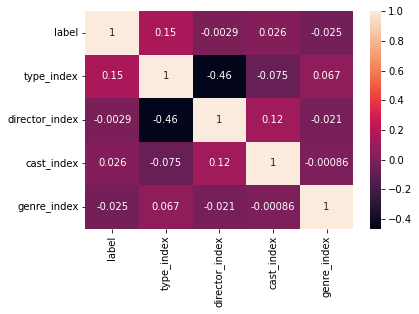

In [43]:
import pandas as pd
import seaborn as sns

# See correlation of the features to label
data = Dis_genre_index.select('label', 'type_index', 'director_index', 'cast_index', 'genre_index').toPandas()
sns.heatmap(data.corr(), annot=True); # output shows that type feature has the highest positive correlation to ratings

In [44]:
# Transform several columns as one Feature column
Disney_Assembler = VectorAssembler(inputCols=['Disney_tfidf', 'type_index', 'director_index', 'cast_index', 'genre_index'], outputCol='features')
Disney_features = Disney_Assembler.transform(Dis_genre_index)
Disney_features.show()

+-------+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+----------+--------------+----------+-----------+--------------------+
|   type|   title_description|            director|                cast|rating|           listed_in|disney_title_desc_tokens|filtered_title_description|    vectorized_words|        Disney_tfidf|label|type_index|director_index|cast_index|genre_index|            features|
+-------+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+----------+--------------+----------+-----------+--------------------+
|  Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|    [duck, the, halls...|      [duck, halls, mic...|(4977,[11,26,38,1...|(4977,[11,26,3

In [45]:
# Creaing data pipeline
Disney_pipeline3 = Pipeline(stages=[Disney_numeric3, Disney_type_indexers, Disney_dir_indexers, Disney_cast_indexers, Disney_genre_indexers, tokenizer1, Disney_remover, Disney_cv, Disney_idf, Disney_Assembler])

# Fitting data to pipeline
Disney_fit3 = Disney_pipeline3.fit(DisneyNLP)
Disney_clean3 = Disney_fit3.transform(DisneyNLP)
Disney_cleaned3 = Disney_clean3.select('label', 'features')
Disney_cleaned3.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(1860,[8,14,37,55...|
|  3.0|(1860,[14,1574,16...|
|  0.0|(1860,[14,59,96,1...|
|  1.0|(1860,[58,173,590...|
|  6.0|(1860,[370,1579,1...|
|  5.0|(1860,[1035,1856,...|
|  5.0|(1860,[243,607,13...|
|  1.0|(1860,[18,122,139...|
|  2.0|(1860,[14,41,112,...|
|  1.0|(1860,[0,72,98,50...|
|  0.0|(1860,[273,1434,1...|
|  2.0|(1860,[6,153,1857...|
|  1.0|(1860,[77,464,111...|
|  1.0|(1860,[30,670,185...|
|  0.0|(1860,[681,1859],...|
|  1.0|(1860,[764,1710,1...|
|  1.0|(1860,[0,255,534,...|
|  1.0|(1860,[0,1630,185...|
|  3.0|(1860,[385,1857,1...|
|  2.0|(1860,[1217,1857,...|
+-----+--------------------+
only showing top 20 rows



Model 4: Using 2 features(director, title_description) against rating as label

In [46]:
# Convert type column to numeric
Disney_dir_indexers = StringIndexer(inputCol='director', outputCol='director_index')
Dis_dir_index = Disney_dir_indexers.fit(Dis_label_index).transform(Dis_label_index)
Dis_dir_index.show(5)

+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+--------------+
| type|   title_description|            director|                cast|rating|           listed_in|disney_title_desc_tokens|filtered_title_description|    vectorized_words|        Disney_tfidf|label|director_index|
+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+--------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|    [duck, the, halls...|      [duck, halls, mic...|(4977,[11,26,38,1...|(4977,[11,26,38,1...|  0.0|         163.0|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|    [ernest, saves, c...|      [ernest, saves,

In [47]:
# Create single feature vector by combining 2 features
Disney_Assembler4 = VectorAssembler(inputCols=['Disney_tfidf', 'director_index'], outputCol='features')
Disney_features4 = Disney_Assembler4.transform(Dis_dir_index)
Disney_features4.show(5)

+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+--------------+--------------------+
| type|   title_description|            director|                cast|rating|           listed_in|disney_title_desc_tokens|filtered_title_description|    vectorized_words|        Disney_tfidf|label|director_index|            features|
+-----+--------------------+--------------------+--------------------+------+--------------------+------------------------+--------------------------+--------------------+--------------------+-----+--------------+--------------------+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|    [duck, the, halls...|      [duck, halls, mic...|(4977,[11,26,38,1...|(4977,[11,26,38,1...|  0.0|         163.0|(4978,[11,26,38,1...|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney,

In [48]:
# Creaing data pipeline
Disney_pipeline4 = Pipeline(stages=[Disney_numeric3, Disney_dir_indexers, tokenizer3, Disney_remover3, Disney_cv3, Disney_idf3, Disney_Assembler4])
Disney_fit4 = Disney_pipeline4.fit(DisneyML1)
Disney_clean4 = Disney_fit4.transform(DisneyML1)
Disney_cleaned4 = Disney_clean4.select('label', 'features')
Disney_cleaned4.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(4978,[11,26,38,1...|
|  3.0|(4978,[5,26,75,93...|
|  0.0|(4978,[26,75,132,...|
|  1.0|(4978,[6,8,119,30...|
|  6.0|(4978,[6,82,209,2...|
+-----+--------------------+
only showing top 5 rows



Model 5: Using cast column and director as features and rating as label

In [49]:
disney_indexer_label = StringIndexer(inputCol='rating', outputCol='label')
disney_indexed_label = disney_indexer_label.fit(DisneyML).transform(DisneyML)
disney_indexed_label.show(5)

# Create indexes for disney_title_words 
disney_indexer_director = StringIndexer(inputCol='director', outputCol='disney_director_index')
disney_indexed_director = disney_indexer_director.fit(disney_indexed_label).transform(disney_indexed_label)
disney_indexed_director.show(5)

#Create indexes for disney_description_tokens
disney_indexer_cast = StringIndexer(inputCol='cast', outputCol='disney_cast_index')
disney_indexed_cast =  disney_indexer_cast.fit(disney_indexed_director).transform(disney_indexed_director)
disney_indexed_cast.show(5)

+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+-----+
| type|               title|            director|                cast|rating|           listed_in|         description|label|
+-----+--------------------+--------------------+--------------------+------+--------------------+--------------------+-----+
|Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|  TV-G|   Animation, Family|Join Mickey and t...|  0.0|
|Movie|Ernest Saves Chri...|         John Cherry|Jim Varney, Noell...|    PG|              Comedy|Santa Claus passe...|  3.0|
|Movie|Ice Age: A Mammot...|        Karen Disher|Raymond Albert Ro...|  TV-G|Animation, Comedy...|Sid the Sloth is ...|  0.0|
|Movie|The Queen Family ...|     Hamish Hamilton|Darren Criss, Ada...| TV-PG|             Musical|This is real life...|  1.0|
|Movie|   Becoming Cousteau|          Liz Garbus|Jacques Yves Cous...| PG-13|Biographical, Doc...|An inside look at...

In [50]:
# Create singel feature vector
Disney_Assembler5 = VectorAssembler(inputCols=['disney_director_index','disney_cast_index'], outputCol='features')

# Creaing data pipeline
Disney_pipeline5 = Pipeline(stages=[disney_indexer_label, disney_indexer_director, disney_indexer_cast, Disney_Assembler5])       
Disney_fit5 = Disney_pipeline5.fit(DisneyML)
Disney_clean5 = Disney_fit5.transform(DisneyML)
Disney_cleaned5 = Disney_clean5.select('label', 'features')
Disney_cleaned5.show(5)

+-----+-------------+
|label|     features|
+-----+-------------+
|  0.0|[163.0,245.0]|
|  3.0|[367.0,603.0]|
|  0.0| [388.0,30.0]|
|  1.0| [97.0,308.0]|
|  6.0|[418.0,530.0]|
+-----+-------------+
only showing top 5 rows



b. Naive Bayes Classifier

In [51]:
# Creating the Naive bayes model
NB = NaiveBayes(modelType="multinomial")

In [52]:
# To be use for mapping prediction to label and rating (label names)
Diney_label_rating = Dis_label_index.select('label', 'rating')
Diney_label_rating.show()

+-----+------+
|label|rating|
+-----+------+
|  0.0|  TV-G|
|  3.0|    PG|
|  0.0|  TV-G|
|  1.0| TV-PG|
|  6.0| PG-13|
|  5.0| TV-14|
|  5.0| TV-14|
|  1.0| TV-PG|
|  2.0|     G|
|  1.0| TV-PG|
|  0.0|  TV-G|
|  2.0|     G|
|  1.0| TV-PG|
|  1.0| TV-PG|
|  0.0|  TV-G|
|  1.0| TV-PG|
|  1.0| TV-PG|
|  1.0| TV-PG|
|  3.0|    PG|
|  2.0|     G|
+-----+------+
only showing top 20 rows



Model 1: Building on Disney dataset with rating as label with title and word count as features

In [53]:
# Splitting data into training and testing datasets 
Disney_train, Disney_test = Disney_cleaned.randomSplit([0.7, 0.3], 42)

# Fitting the Naive Bayes model
Disney_model = NB.fit(Disney_train)
Disney_results = Disney_model.transform(Disney_test)

# Mapping result with label to rating
Disney_df = Disney_results.join(Diney_label_rating, Diney_label_rating.label == Disney_results.label)
Disney_df.show()
#Disney_results.show()

+-----+--------------------+--------------------+--------------------+----------+-----+------+
|label|            features|       rawPrediction|         probability|prediction|label|rating|
+-----+--------------------+--------------------+--------------------+----------+-----+------+
|  0.0|(1857,[1805,1856]...|[-69.997390151339...|[0.06760218741973...|       4.0|  0.0|  TV-G|
|  0.0|(1857,[1679,1856]...|[-67.684397974847...|[0.03306014266282...|       5.0|  0.0|  TV-G|
|  0.0|(1857,[1617,1640,...|[-131.54751584388...|[4.68425670273936...|       7.0|  0.0|  TV-G|
|  0.0|(1857,[1309,1856]...|[-69.226392759175...|[0.05521762984835...|       4.0|  0.0|  TV-G|
|  0.0|(1857,[1299,1856]...|[-68.455395367011...|[0.04353618316520...|       4.0|  0.0|  TV-G|
|  0.0|(1857,[1285,1772,...|[-132.31851323605...|[7.27033257698031...|       5.0|  0.0|  TV-G|
|  0.0|(1857,[1271,1856]...|[-66.913400582682...|[0.02415417918244...|       5.0|  0.0|  TV-G|
|  0.0|(1857,[1232,1856]...|[-71.539384935667...|[

Model 2: Building on Disney dataset with rating as label with description and word count as features

In [54]:
# Splitting data into training and testing datasets 
Disney_train2, Disney_test2 = Disney_cleaned2.randomSplit([0.7, 0.3], 42)

# Fitting the Naive Bayes model
Disney_model2 = NB.fit(Disney_train2)
Disney_results2 = Disney_model2.transform(Disney_test2)

# Mapping result with label to rating
Disney_df2 = Disney_results2.join(Diney_label_rating, Diney_label_rating.label == Disney_results2.label)
Disney_df2.show()

+-----+--------------------+--------------------+--------------------+----------+-----+------+
|label|            features|       rawPrediction|         probability|prediction|label|rating|
+-----+--------------------+--------------------+--------------------+----------+-----+------+
|  0.0|(4373,[1178,1227,...|[-435.42347293362...|[2.57037175956110...|       6.0|  0.0|  TV-G|
|  0.0|(4373,[520,553,94...|[-463.97905722742...|[0.99874000118779...|       0.0|  0.0|  TV-G|
|  0.0|(4373,[371,1227,1...|[-492.48633033931...|[1.70246309947075...|       3.0|  0.0|  TV-G|
|  0.0|(4373,[204,409,65...|[-403.71408972295...|[1.0,1.4111074198...|       0.0|  0.0|  TV-G|
|  0.0|(4373,[196,213,58...|[-402.49385324326...|[1.04096983662785...|       2.0|  0.0|  TV-G|
|  0.0|(4373,[179,308,53...|[-547.22426725874...|[0.99999901392323...|       0.0|  0.0|  TV-G|
|  0.0|(4373,[179,234,26...|[-532.51700928049...|[0.94337930536603...|       0.0|  0.0|  TV-G|
|  0.0|(4373,[173,179,26...|[-502.00231971896...|[

Model 3: Building on Disney dataset with rating as label with combined title_description, type, director, cast, and listed_in as features

In [55]:
# Splitting data into training and testing datasets 
Disney_train3, Disney_test3 = Disney_cleaned3.randomSplit([0.7, 0.3], 42)

# Fitting the Naive Bayes model
Disney_model3 = NB.fit(Disney_train3)
Disney_results3 = Disney_model3.transform(Disney_test3)
Disney_results3 = Disney_results3.select('label', 'features', 'probability', 'prediction')

# Mapping result with label to rating
Disney_df3 = Disney_results3.join(Diney_label_rating, Diney_label_rating.label == Disney_results3.label)
Disney_df3.show()

+-----+--------------------+--------------------+----------+-----+------+
|label|            features|         probability|prediction|label|rating|
+-----+--------------------+--------------------+----------+-----+------+
|  0.0|(1860,[1805,1856,...|[1.37534353435164...|       4.0|  0.0|  TV-G|
|  0.0|(1860,[1679,1856,...|[5.53320936961734...|       7.0|  0.0|  TV-G|
|  0.0|(1860,[1617,1640,...|[2.72483557738442...|       3.0|  0.0|  TV-G|
|  0.0|(1860,[1309,1856,...|[2.15929501221204...|       7.0|  0.0|  TV-G|
|  0.0|(1860,[1299,1856,...|[2.32172652153523...|       7.0|  0.0|  TV-G|
|  0.0|(1860,[1285,1772,...|[7.46538776802552...|       3.0|  0.0|  TV-G|
|  0.0|(1860,[1271,1857,...|[5.14152621483803...|       2.0|  0.0|  TV-G|
|  0.0|(1860,[1232,1857,...|[2.00743312433090...|       9.0|  0.0|  TV-G|
|  0.0|(1860,[1227,1856,...|[6.30856548098974...|       7.0|  0.0|  TV-G|
|  0.0|(1860,[1191,1856,...|[6.91131224002622...|       5.0|  0.0|  TV-G|
|  0.0|(1860,[1080,1111,...|[9.3856448

Model 4: Building on Disney dataset with rating as label with combined title_description, and director as features

In [56]:
# Splitting data into training and testing datasets 
Disney_train4, Disney_test4 = Disney_cleaned4.randomSplit([0.7, 0.3], 42)

# Fitting the Naive Bayes model
Disney_model4 = NB.fit(Disney_train4)
Disney_results4 = Disney_model4.transform(Disney_test4)
Disney_results4 = Disney_results4.select('label', 'features', 'probability', 'prediction')

# Mapping result with label to rating
Disney_df4 = Disney_results4.join(Diney_label_rating, Diney_label_rating.label == Disney_results4.label)
Disney_df4.show()

+-----+--------------------+--------------------+----------+-----+------+
|label|            features|         probability|prediction|label|rating|
+-----+--------------------+--------------------+----------+-----+------+
|  0.0|(4978,[424,607,10...|[1.31846408711039...|       3.0|  0.0|  TV-G|
|  0.0|(4978,[293,309,58...|[2.06400109453335...|       9.0|  0.0|  TV-G|
|  0.0|(4978,[287,406,10...|[7.38305453166451...|      10.0|  0.0|  TV-G|
|  0.0|(4978,[139,140,24...|[3.04784821212518...|       7.0|  0.0|  TV-G|
|  0.0|(4978,[136,183,22...|[2.10700468215555...|       3.0|  0.0|  TV-G|
|  0.0|(4978,[123,317,50...|[1.33772768274242...|       9.0|  0.0|  TV-G|
|  0.0|(4978,[112,274,74...|[5.28754885792644...|       2.0|  0.0|  TV-G|
|  0.0|(4978,[110,133,21...|[1.07993775688854...|       2.0|  0.0|  TV-G|
|  0.0|(4978,[99,199,621...|[2.04257521461063...|       3.0|  0.0|  TV-G|
|  0.0|(4978,[96,227,237...|[2.99169147680280...|       8.0|  0.0|  TV-G|
|  0.0|(4978,[89,463,896...|[8.0263043

Model 5: Using director column and word count as features and rating as label

In [57]:
# Splitting data into training and testing datasets 
Disney_train5, Disney_test5 = Disney_cleaned5.randomSplit([0.7, 0.3], 42)

# Fitting the Naive Bayes model
Disney_model5 = NB.fit(Disney_train5)
Disney_results5 = Disney_model5.transform(Disney_test5)
Disney_results5 = Disney_results5.select('label', 'features', 'probability', 'prediction')

# Mapping result with label to rating
Disney_df5 = Disney_results5.join(Diney_label_rating, Diney_label_rating.label == Disney_results5.label)
Disney_df5.show()

+-----+--------------+--------------------+----------+-----+------+
|label|      features|         probability|prediction|label|rating|
+-----+--------------+--------------------+----------+-----+------+
|  0.0| [608.0,724.0]|[6.08348464226433...|       9.0|  0.0|  TV-G|
|  0.0| [573.0,134.0]|[2.52532798113609...|       9.0|  0.0|  TV-G|
|  0.0| [557.0,693.0]|[1.95635246814880...|       9.0|  0.0|  TV-G|
|  0.0| [476.0,198.0]|[9.0076648916105E...|       9.0|  0.0|  TV-G|
|  0.0| [471.0,204.0]|[1.24878296480171...|       9.0|  0.0|  TV-G|
|  0.0| [459.0,604.0]|[6.45746253409383...|       9.0|  0.0|  TV-G|
|  0.0|   [452.0,0.0]|[2.23762609600578...|       9.0|  0.0|  TV-G|
|  0.0| [449.0,618.0]|[2.83526003842072...|       9.0|  0.0|  TV-G|
|  0.0|[448.0,1036.0]|[3.16898587900903...|       3.0|  0.0|  TV-G|
|  0.0| [433.0,512.0]|[1.11395954621255...|       9.0|  0.0|  TV-G|
|  0.0| [398.0,213.0]|[7.37470770490985...|       9.0|  0.0|  TV-G|
|  0.0|   [264.0,0.0]|[1.03210373833920...|     

# A.2 Model Evaluation

In [58]:
# Evaluating NB model 1
accuracy_eval = MulticlassClassificationEvaluator()
accuracy = accuracy_eval.evaluate(Disney_results)
print(accuracy)

0.3568553206421365


In [59]:
# Evaluating NB model 2
accuracy_eval2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy2 = accuracy_eval2.evaluate(Disney_results2)
print(accuracy2)

0.3393782383419689


In [60]:
# Evaluating NB model 3
accuracy_eval3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy3 = accuracy_eval3.evaluate(Disney_results3)
print(accuracy3)

0.19430051813471502


In [61]:
# Evaluating NB model 4
accuracy_eval4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy4 = accuracy_eval4.evaluate(Disney_results4)
print(accuracy4)

0.31088082901554404


In [62]:
# Evaluating NB model 5
accuracy_eval5 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy5 = accuracy_eval5.evaluate(Disney_results5)
print(accuracy5)

0.12953367875647667


# B. Netflix Data

In [63]:
NetflixML = netflixEDA.select("type", "title", "director", "cast", "rating", "listed_in", "description")
NetflixML.show()

+-------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|   type|               title|            director|                cast|rating|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|
|TV Show|       Blood & Water|                    |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|
|TV Show|           Ganglands|     Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|To protect his fa...|
|TV Show|Jailbirds New Orl...|                    |                    | TV-MA|Docuseries, Reali...|Feuds, flirtation...|
|TV Show|        Kota Factory|                    |Mayur More, Jiten...| TV-MA|International TV ...|In a city of coac...|
|TV Show|       Midnight

In [64]:
NetflixML.select("rating").distinct().show()
NetflixML.select("rating").distinct().count()

+--------------------+
|              rating|
+--------------------+
|    November 1, 2020|
|    Shavidee Trotter|
|       Adriane Lenox|
|                TV-Y|
|       Maury Chaykin|
|                2019|
|                2017|
|                  UR|
| Keppy Ekpenyong ...|
|      Benn Northover|
|                  PG|
|         Jide Kosoko|
|               TV-MA|
|     Jowharah Jones"|
|            TV-Y7-FV|
|                2006|
|      Itziar Aizpuru|
|                  NR|
|               TV-PG|
|               NC-17|
+--------------------+
only showing top 20 rows



32

# B.1 Model Building

a. Natural Language Processing

Model 6: Running model on Netflix title column and word count as features

In [65]:
# Creating index for rating
Netflix_numeric = StringIndexer(inputCol='rating', outputCol='label')
Netflix_label_index = Netflix_numeric.fit(NetflixML).transform(NetflixML)
Netflix_label_index.show(3)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+-----+
|   type|               title|       director|                cast|rating|           listed_in|         description|label|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+-----+
|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|  4.0|
|TV Show|       Blood & Water|               |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|  0.0|
|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|To protect his fa...|  0.0|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+-----+
only showing top 3 rows



In [66]:
NetflixNLP = NetflixML.withColumn('title_length', length(NetflixML['title']))
NetflixNLP.show(5)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+
|   type|               title|       director|                cast|rating|           listed_in|         description|title_length|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+
|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|          20|
|TV Show|       Blood & Water|               |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|          13|
|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|To protect his fa...|           9|
|TV Show|Jailbirds New Orl...|               |                    | TV-MA|Docuseries, Reali...|Feuds, flirtation...|          21|
|TV Show|        Kota Factory|               |Mayur More, Jiten...| TV-MA|International TV

In [67]:
# Tokenize words in title column
Net_tokenizer1 = RegexTokenizer(inputCol="title", outputCol="Net_words", pattern='\\W')
Net_tokenized1 = Net_tokenizer1.transform(NetflixNLP)

# Remove stopwords in tokenized words column
Netflix_remover = StopWordsRemover(inputCol='Net_words', outputCol='filtered_title')
removed_Netflix = Netflix_remover.transform(Net_tokenized1)

# Processing title column
Netflix_cv1 = CountVectorizer(inputCol='filtered_title', outputCol='vec_title')
Net_vectorized1 = Netflix_cv1.fit(removed_Netflix).transform(removed_Netflix)
Net_vectorized1.show(5)

Netflix_idf1 = IDF(inputCol='vec_title', outputCol='Netflix_tfidf')
Netflix_TF_IDF1 = Netflix_idf1.fit(Net_vectorized1).transform(Net_vectorized1)

# Create single feature vector features
Netflix_Assembler = VectorAssembler(inputCols=['Netflix_tfidf','title_length'], outputCol='features')

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|   type|               title|       director|                cast|rating|           listed_in|         description|title_length|           Net_words|      filtered_title|           vec_title|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|          20|[dick, johnson, i...|[dick, johnson, d...|(8785,[87,853,140...|
|TV Show|       Blood & Water|               |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|          13|      [blood, water]|      [blood, water]|(8785,[89,159],[1...|
|TV Show|           Ganglands|Julie

In [68]:
# Using description length for transforming features later on
NetflixNLP = NetflixNLP.withColumn('description_length', length(NetflixNLP['description']))
NetflixNLP.show(5)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+------------------+
|   type|               title|       director|                cast|rating|           listed_in|         description|title_length|description_length|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+------------------+
|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|          20|               152|
|TV Show|       Blood & Water|               |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|          13|               147|
|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|To protect his fa...|           9|               146|
|TV Show|Jailbirds New Orl...|               |                    | TV-MA|Docuseries, Reali...|Feuds, flir

In [69]:
# Building data pipeline and fitting to data
Netflix_pipeline1 = Pipeline(stages=[Netflix_numeric, Net_tokenizer1, Netflix_remover, Netflix_cv1, Netflix_idf1, Netflix_Assembler])  
Netflix_fit1 = Netflix_pipeline1.fit(NetflixNLP)
Netflix_clean1 = Netflix_fit1.transform(NetflixNLP)
Netflix_cleaned1 = Netflix_clean1.select('label', 'features')
Netflix_cleaned1.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|(8786,[87,853,140...|
|  0.0|(8786,[89,159,878...|
|  0.0|(8786,[4587,8785]...|
|  0.0|(8786,[27,2626,81...|
|  0.0|(8786,[479,4220,8...|
+-----+--------------------+
only showing top 5 rows



Model 7: Running on Netflix data using description column and word count as features

In [70]:
# Tokenize words in description column
Net_tokenizer2 = RegexTokenizer(inputCol="description", outputCol="Net_tokens", pattern='\\W')
Net_tokenized2 = Net_tokenizer2.transform(Net_tokenized1)
Net_tokenized2.show(5)

# Remove stopwords in tokenized Net_tokens column
Netflix_remover2 = StopWordsRemover(inputCol='Net_tokens', outputCol='filtered_description')
removed_Netflix2 = Netflix_remover2.transform(Net_tokenized2)

# Processing Netflix description column
Netflix_cv2 = CountVectorizer(inputCol='filtered_description', outputCol='vec_description')
Net_vectorized2 = Netflix_cv2.fit(removed_Netflix2).transform(removed_Netflix2)
Net_vectorized2.show(5)

Netflix_idf2 = IDF(inputCol='vec_description', outputCol='Netflix_tfidf2')
Netflix_TF_IDF2 = Netflix_idf2.fit(Net_vectorized2).transform(Net_vectorized2)

# Creating index for rating
Netflix_numeric2 = StringIndexer(inputCol='rating', outputCol='label')

# Vectorized features in single vector
Netflix_Assembler2 = VectorAssembler(inputCols=['Netflix_tfidf2','description_length'], outputCol='features')


+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+
|   type|               title|       director|                cast|rating|           listed_in|         description|title_length|           Net_words|          Net_tokens|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+------------+--------------------+--------------------+
|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                    | PG-13|       Documentaries|As her father nea...|          20|[dick, johnson, i...|[as, her, father,...|
|TV Show|       Blood & Water|               |Ama Qamata, Khosi...| TV-MA|International TV ...|After crossing pa...|          13|      [blood, water]|[after, crossing,...|
|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|To protect his fa...|           9|         [g

In [71]:
# Creaing data pipeline
Netflix_pipeline2 = Pipeline(stages=[Netflix_numeric2, Net_tokenizer2, Netflix_remover2, Netflix_cv2, Netflix_idf2, Netflix_Assembler2]) 
Netflix_fit2 = Netflix_pipeline2.fit(NetflixNLP)
Netflix_clean2 = Netflix_fit2.transform(NetflixNLP)
Netflix_cleaned2 = Netflix_clean2.select('label', 'features')
Netflix_cleaned2.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|(18945,[0,16,22,4...|
|  0.0|(18945,[15,33,35,...|
|  0.0|(18945,[3,41,42,9...|
|  0.0|(18945,[2,11,56,1...|
|  0.0|(18945,[0,9,31,68...|
|  0.0|(18945,[1,33,258,...|
|  7.0|(18945,[121,163,1...|
|  0.0|(18945,[29,43,46,...|
|  1.0|(18945,[52,114,18...|
|  4.0|(18945,[0,8,14,62...|
|  0.0|(18945,[55,224,24...|
|  0.0|(18945,[5,10,147,...|
|  0.0|(18945,[1,3,8,25,...|
|  2.0|(18945,[2,15,238,...|
|  0.0|(18945,[40,55,85,...|
|  0.0|(18945,[0,105,178...|
|  0.0|(18945,[0,4,432,5...|
|  0.0|(18945,[17,73,95,...|
|  1.0|(18945,[2,17,47,7...|
|  0.0|(18945,[25,182,23...|
+-----+--------------------+
only showing top 20 rows



Model 8: Building model on rating as label and combining title & description column and actor column as features

In [72]:
# Combining Title and description in one column to be used later
NetflixML1 = NetflixML.select("type", concat_ws(' ',NetflixML.title, NetflixML.description)
              .alias("title_description"),"director","cast","rating", "listed_in")
NetflixML1.show(5, truncate=False)
NetflixML1.printSchema()

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-------------------------------------------------------------+
|type   |title_description                                                                                                                                                            |director       |cast                                                                                                                                                                                                                                

In [73]:
# Tokenize words in title_description column
Net_tokenizer3 = RegexTokenizer(inputCol= 'title_description', outputCol='Netflix_tokens', pattern='\\W')
tokenized3 = Net_tokenizer3.transform(NetflixML1)
tokenized3.show(5)

# Remove stopwords in tokenized Netflix_tokens column
Netflix_remover3 = StopWordsRemover(inputCol='Netflix_tokens', outputCol='filtered_title_description')
removed_Netflix = Netflix_remover3.transform(tokenized3)
removed_Netflix.show(5)

# Count Vectorization on filtered_title_description column
Netflix_cv3 = CountVectorizer(inputCol='filtered_title_description', outputCol='vectorized_words')
vectorized_Net3 = Netflix_cv3.fit(removed_Netflix).transform(removed_Netflix)
vectorized_Net3.show(5)

# Get the TF-IDF
Netflix_idf3 = IDF(inputCol='vectorized_words', outputCol='Netflix_tfidf')
Netflix_TF_IDF3 = Netflix_idf3.fit(vectorized_Net3).transform(vectorized_Net3)
Netflix_TF_IDF3.show(5)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+
|   type|   title_description|       director|                cast|rating|           listed_in|      Netflix_tokens|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+
|  Movie|Dick Johnson Is D...|Kirsten Johnson|                    | PG-13|       Documentaries|[dick, johnson, i...|
|TV Show|Blood & Water Aft...|               |Ama Qamata, Khosi...| TV-MA|International TV ...|[blood, water, af...|
|TV Show|Ganglands To prot...|Julien Leclercq|Sami Bouajila, Tr...| TV-MA|Crime TV Shows, I...|[ganglands, to, p...|
|TV Show|Jailbirds New Orl...|               |                    | TV-MA|Docuseries, Reali...|[jailbirds, new, ...|
|TV Show|Kota Factory In a...|               |Mayur More, Jiten...| TV-MA|International TV ...|[kota, factory, i...|
+-------+--------------------+---------------+------------------

In [74]:
# Convert type column to numeric
Netflix_dir_indexers2 = StringIndexer(inputCol='director', outputCol='director_index')
Netflix_dir_index2 = Netflix_dir_indexers2.fit(Netflix_TF_IDF3).transform(Netflix_TF_IDF3)
Netflix_dir_index2.show(5)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------+
|   type|   title_description|       director|                cast|rating|           listed_in|      Netflix_tokens|filtered_title_description|    vectorized_words|       Netflix_tfidf|director_index|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------+
|  Movie|Dick Johnson Is D...|Kirsten Johnson|                    | PG-13|       Documentaries|[dick, johnson, i...|      [dick, johnson, d...|(22363,[0,18,22,4...|(22363,[0,18,22,4...|        2756.0|
|TV Show|Blood & Water Aft...|               |Ama Qamata, Khosi...| TV-MA|International TV ...|[blood, water, af...|      [blood, water, cr...|(22363,[13,37,48,...|(22363,[13,37,48,...|           

In [75]:
# Transform several columns as one Feature column
Netflix_Assembler3 = VectorAssembler(inputCols=['Netflix_tfidf', 'director_index'], outputCol='features')
Netflix_features3 = Netflix_Assembler3.transform(Netflix_dir_index2)
Netflix_features3.show(5)

+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------+--------------------+
|   type|   title_description|       director|                cast|rating|           listed_in|      Netflix_tokens|filtered_title_description|    vectorized_words|       Netflix_tfidf|director_index|            features|
+-------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------+--------------------+
|  Movie|Dick Johnson Is D...|Kirsten Johnson|                    | PG-13|       Documentaries|[dick, johnson, i...|      [dick, johnson, d...|(22363,[0,18,22,4...|(22363,[0,18,22,4...|        2756.0|(22364,[0,18,22,4...|
|TV Show|Blood & Water Aft...|               |Ama Qamata, Khosi...| TV-MA|International TV ...|[blood, water, af

In [76]:
# Creaing data pipeline
Netflix_pipeline3 = Pipeline(stages=[Netflix_numeric, Netflix_dir_indexers2, Net_tokenizer3, Netflix_remover3, Netflix_cv3, Netflix_idf3, Netflix_Assembler3])
Netflix_fit3 = Netflix_pipeline3.fit(NetflixML1)
Netflix_clean3 = Netflix_fit3.transform(NetflixML1)
Netflix_cleaned3 = Netflix_clean3.select('label', 'features')
Netflix_cleaned3.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|(22364,[0,18,22,4...|
|  0.0|(22364,[13,37,48,...|
|  0.0|(22364,[4,34,45,1...|
|  0.0|(22364,[1,11,57,8...|
|  0.0|(22364,[0,9,26,73...|
|  0.0|(22364,[2,37,305,...|
|  7.0|(22364,[1,98,109,...|
|  0.0|(22364,[29,30,52,...|
|  1.0|(22364,[43,51,123...|
|  4.0|(22364,[0,8,16,65...|
|  0.0|(22364,[54,217,25...|
|  0.0|(22364,[6,12,154,...|
|  0.0|(22364,[2,4,8,27,...|
|  2.0|(22364,[1,13,23,2...|
|  0.0|(22364,[46,54,61,...|
|  0.0|(22364,[0,99,117,...|
|  0.0|(22364,[0,5,6,162...|
|  0.0|(22364,[17,83,107...|
|  1.0|(22364,[1,17,55,8...|
|  0.0|(22364,[27,211,27...|
+-----+--------------------+
only showing top 20 rows



In [77]:
# Used for mapping prediction to label name (rating)
Netflix_label_rating = Netflix_label_index.select('label', 'rating')
Netflix_label_rating.show()

+-----+------+
|label|rating|
+-----+------+
|  4.0| PG-13|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  7.0|    PG|
|  0.0| TV-MA|
|  1.0| TV-14|
|  4.0| PG-13|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  2.0| TV-PG|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  0.0| TV-MA|
|  1.0| TV-14|
|  0.0| TV-MA|
+-----+------+
only showing top 20 rows



b. Naive bayes Models

Model 6: title and title word count as features and rating as label

In [78]:
# Splitting data into training and testing datasets 
Netflix_train1, Netflix_test1 = Netflix_cleaned1.randomSplit([0.7, 0.3])

# Fitting the Naive Bayes model 7
Netflix_model1 = NB.fit(Netflix_train1)
Netflix_results1 = Netflix_model1.transform(Netflix_test1)

# Mapping result with label to rating
Netflix_df1 = Netflix_results1.join(Netflix_label_rating, Netflix_label_rating.label == Netflix_results1.label)
Netflix_df1.show()

+-----+--------------------+--------------------+--------------------+----------+-----+------+
|label|            features|       rawPrediction|         probability|prediction|label|rating|
+-----+--------------------+--------------------+--------------------+----------+-----+------+
|  4.0|(8786,[8762,8785]...|[-105.89860740407...|[0.00141123057245...|       3.0|  4.0| PG-13|
|  4.0|(8786,[8710,8785]...|[-102.68908594969...|[2.44804724455436...|       4.0|  4.0| PG-13|
|  4.0|(8786,[8708,8785]...|[-100.28194485890...|[5.26373315288817...|       7.0|  4.0| PG-13|
|  4.0|(8786,[8707,8785]...|[-101.88670558610...|[1.49971908385425...|       4.0|  4.0| PG-13|
|  4.0|(8786,[8532,8785]...|[-101.88670558610...|[1.49971908385425...|       4.0|  4.0| PG-13|
|  4.0|(8786,[8405,8785]...|[-105.89860740407...|[0.00141123057245...|       3.0|  4.0| PG-13|
|  4.0|(8786,[7876,8785]...|[-99.479564495313...|[2.96033437696312...|       7.0|  4.0| PG-13|
|  4.0|(8786,[7792,8785]...|[-102.68908594969...|[

Model 7: description and description word count as features

In [79]:
# Splitting data into training and testing datasets 
Netflix_train2, Netflix_test2 = Netflix_cleaned2.randomSplit([0.7, 0.3])

# Fitting the Naive Bayes model 8
Netflix_model2 = NB.fit(Netflix_train2)
Netflix_results2 = Netflix_model2.transform(Netflix_test2)

# Mapping result with label to rating
Netflix_df2 = Netflix_results2.join(Netflix_label_rating, Netflix_label_rating.label == Netflix_results2.label)
Netflix_df2.show()

+-----+--------------------+--------------------+--------------------+----------+-----+------+
|label|            features|       rawPrediction|         probability|prediction|label|rating|
+-----+--------------------+--------------------+--------------------+----------+-----+------+
|  4.0|(18945,[175,247,4...|[-979.53349579347...|[1.34634698637065...|       5.0|  4.0| PG-13|
|  4.0|(18945,[171,205,4...|[-1119.4234744956...|[0.39667723415703...|       2.0|  4.0| PG-13|
|  4.0|(18945,[146,359,6...|[-1053.2259983009...|[1.69290846003333...|       3.0|  4.0| PG-13|
|  4.0|(18945,[127,423,6...|[-1046.1620957400...|[1.0,2.2995912123...|       0.0|  4.0| PG-13|
|  4.0|(18945,[109,122,2...|[-1130.7103688233...|[1.38611838666340...|       8.0|  4.0| PG-13|
|  4.0|(18945,[108,187,2...|[-986.71177653646...|[5.14916632197570...|       4.0|  4.0| PG-13|
|  4.0|(18945,[105,112,4...|[-1033.6582209314...|[2.32349794192202...|       7.0|  4.0| PG-13|
|  4.0|(18945,[104,107,2...|[-959.31475237043...|[

Model 8: Combined title_description and actor as features

In [80]:
# Splitting data into training and testing datasets 
Netflix_train3, Netflix_test3 = Netflix_cleaned3.randomSplit([0.7, 0.3])

# Fitting the Naive Bayes model 9
Netflix_model3 = NB.fit(Netflix_train3)
Netflix_results3 = Netflix_model3.transform(Netflix_test3)

# Mapping result with label to rating
Netflix_df3 = Netflix_results3.join(Netflix_label_rating, Netflix_label_rating.label == Netflix_results3.label)
Netflix_df3.show()

+-----+--------------------+--------------------+--------------------+----------+-----+------+
|label|            features|       rawPrediction|         probability|prediction|label|rating|
+-----+--------------------+--------------------+--------------------+----------+-----+------+
|  4.0|(22364,[191,505,5...|[-960.73526847711...|[3.90582478452726...|       4.0|  4.0| PG-13|
|  4.0|(22364,[119,188,4...|[-1042.7390411900...|[5.64679401823554...|       7.0|  4.0| PG-13|
|  4.0|(22364,[111,143,1...|[-1160.0365047978...|[2.38824527147181...|       3.0|  4.0| PG-13|
|  4.0|(22364,[103,422,5...|[-1290.0617952920...|[5.55798850524394...|       3.0|  4.0| PG-13|
|  4.0|(22364,[101,112,2...|[-1383.5857052563...|[1.04061615932113...|       4.0|  4.0| PG-13|
|  4.0|(22364,[99,122,22...|[-1371.0539007093...|[1.42676106615635...|      13.0|  4.0| PG-13|
|  4.0|(22364,[94,197,29...|[-1255.9301295858...|[2.80813489538681...|       5.0|  4.0| PG-13|
|  4.0|(22364,[89,113,62...|[-1559.9599012004...|[

# B.2 Model Evaluation

Model 6: Running NB model on Netflix title column

In [81]:
# Evaluating NB model 6
accuracy_eval6 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy6 = accuracy_eval6.evaluate(Netflix_results1)
print(accuracy6)

0.23472065991751032


Model 7: Running NB model on Netflix description column

In [82]:
accuracy_eval7 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy7 = accuracy_eval7.evaluate(Netflix_results2)
print(accuracy7)

0.34532095901005416


Model 8: Running NB model on Netflix combined title_description and actor columns

In [83]:
accuracy_eval8 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy8 = accuracy_eval8.evaluate(Netflix_results3)
print(accuracy8)

0.19695817490494297
